## Part 04: Batch Inference

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Setup & Station Metadata

In [2]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\lppap\Documents\master\scalable_ML\mlfs-book
HopsworksSettings initialized!


In [3]:
import os
import json
import datetime
import pandas as pd
import matplotlib
import hopsworks
from pathlib import Path
from xgboost import XGBRegressor
from mlfs.airquality import util
from mlfs import config
import matplotlib.dates as mdates

In [6]:
#  Connect to Hopsworks Feature Store
project = hopsworks.login(engine="python")
fs = project.get_feature_store()
secrets = hopsworks.get_secrets_api()

AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value

secret_name = os.getenv("SENSOR_LOCATION_JSON", "SENSOR_LOCATION_JSON")
secret = secrets.get_secret(secret_name).value
station_meta = json.loads(secret)

STATION_UID = station_meta["station_uid"]
CITY = station_meta["city"]
STREET = station_meta["street"]
COUNTRY = station_meta["country"]

print(f"Running hindcast for station {STATION_UID} ({CITY}, {STREET})")

today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days=1)

2025-11-16 09:57:11,224 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 09:57:11,229 INFO: Initializing external client
2025-11-16 09:57:11,229 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 09:57:12,422 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279154


KeyError: 'SENSOR_LOCATION_JSON'

## <span style="color:#ff5f27;">🪝 Download & Load the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="stations_air_quality_xgboost_model_several_stations_lag",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-15 15:50:56,350 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/611827 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28007 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120875 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113670 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112860 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113858 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112102 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112057 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112108 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113061 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114216 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
retrieved_xgboost_model = XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.1244957E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">🪝 Get Weather Forecast Features with Feature View</span>

In [36]:
# Get Weather Forecast Features with Feature View
station_fg = fs.get_feature_group(
    name='stations_air_quality_daily',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

# Weather from yesterday onwards for this city
batch_data_weather = weather_fg.filter(
    (weather_fg.date >= yesterday) & (weather_fg.city == CITY)).read()

# Historical station data of today
batch_data_air = station_fg.filter(
    (station_fg.date >= yesterday) & (station_fg.station_uid == STATION_UID)
).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.26s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


### <span style="color:#ff5f27;">🤖 Making the predictions + Saving predictions (for monitoring) to a Feature Group</span>

In [55]:
# Auto-regressive prediction

# 1) Prepare lag variables from the existing row
row_air = batch_data_air.iloc[0]

pm25_t1 = float(row_air["pm25_t1"])
pm25_t2 = float(row_air["pm25_t2"])
pm25_t3 = float(row_air["pm25_t3"])

station_id = int(row_air["station_uid"])

predictions = []
used_t1 = []
used_t2 = []
used_t3 = []

# 2) Forecast autoregressive
for i in range(len(batch_data_weather)):
    w = batch_data_weather.iloc[i]

    used_t1.append(pm25_t1)
    used_t2.append(pm25_t2)
    used_t3.append(pm25_t3)

    X_input = pd.DataFrame([{
        "station_uid": STATION_UID,
        "pm25_t1": pm25_t1,
        "pm25_t2": pm25_t2,
        "pm25_t3": pm25_t3,
        "temperature_2m_mean": w["temperature_2m_mean"],
        "precipitation_sum": w["precipitation_sum"],
        "wind_speed_10m_max": w["wind_speed_10m_max"],
        "wind_direction_10m_dominant": w["wind_direction_10m_dominant"],
    }])

    pred = retrieved_xgboost_model.predict(X_input)[0]
    predictions.append(pred)

    # shift autoregressive
    pm25_t3 = pm25_t2
    pm25_t2 = pm25_t1
    pm25_t1 = pred

# 3) Build Final Dataframe
batch_data = batch_data_weather.copy()
batch_data["station_uid"] = STATION_UID
batch_data["pm25_t1_used"] = used_t1
batch_data["pm25_t2_used"] = used_t2
batch_data["pm25_t3_used"] = used_t3
batch_data["predicted_pm25"] = predictions
batch_data["street"] = row_air["street"]
batch_data["city"] = row_air["city"]
batch_data["country"] = row_air["country"]


batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,station_uid,pm25_t1_used,pm25_t2_used,pm25_t3_used,street,country
0,2025-11-16 00:00:00+00:00,11.35,0.0,7.280550,171.469315,Vienna,71.749626,2870,61.000000,61.000000,61.000000,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
1,2025-11-15 00:00:00+00:00,8.40,0.1,6.379216,106.389618,Vienna,80.911819,2870,71.749626,61.000000,61.000000,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
2,2025-11-18 00:00:00+00:00,6.10,0.0,15.042659,291.037567,Vienna,61.209312,2870,80.911819,71.749626,61.000000,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
3,2025-11-17 00:00:00+00:00,9.50,2.5,14.372974,292.067963,Vienna,60.996124,2870,61.209312,80.911819,71.749626,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
4,2025-11-19 00:00:00+00:00,5.75,0.0,13.684735,153.435013,Vienna,69.166077,2870,60.996124,61.209312,80.911819,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
5,2025-11-20 00:00:00+00:00,5.80,0.0,2.305125,128.659836,Vienna,80.142662,2870,69.166077,60.996124,61.209312,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria
6,2025-11-21 00:00:00+00:00,4.00,0.1,10.799999,306.869965,Vienna,74.639503,2870,80.142662,69.166077,60.996124,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",Austria


In [58]:
# 4) Save Results to predictions Feature Group
monitor_fg = fs.get_or_create_feature_group(
    name="stations_air_quality_predictions",
    version=1,
    description="Predicted PM2.5 per station per date with multiple stations and sliding window",
    primary_key=["station_uid", "date"],
)

# Insert predictions for monitoring
monitor_fg.insert(batch_data)
print("Predictions successfully saved to Feature Group 'stations_air_quality_predictions'")

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


2025-11-15 16:36:05,054 WARNING: UserWarning: Materialization job is already running, aborting new execution.Please wait for the current execution to finish before triggering a new one.You can check the status of the current execution using `fg.materialization_job.get_state()`.or `fg.materialization_job.get_final_state()` or check it out in the Hopsworks UI.at https://c.app.hopsworks.ai:443/p/1279154/jobs/named/stations_air_quality_predictions_1_offline_fg_materialization.
Use fg.materialization_job.run(args=-op offline_fg_materialization -path hdfs:///Projects/scalable_ml_p1/Resources/jobs/stations_air_quality_predictions_1_offline_fg_materialization/config_1763220875260) to trigger the materialization job again.

Predictions successfully saved to Feature Group 'stations_air_quality_predictions'


### <span style="color:#ff5f27;">🤖 Create Forecast Graph</span>
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

Generating forecast plot for Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816 (UID: 2870)


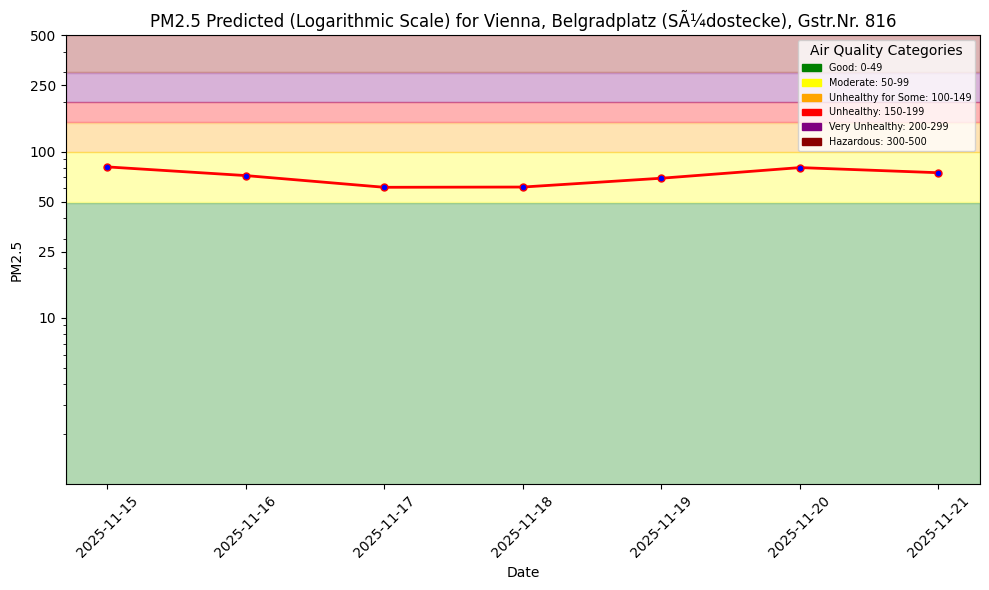

In [67]:
# Weekly Prediction
base_img_dir = f"{root_dir}/docs/air-quality/assets/img/"
os.makedirs(base_img_dir, exist_ok=True)

# Filter prediction data for this station
df_station = batch_data.sort_values(by="date").reset_index(drop=True)

station_dir = os.path.join(base_img_dir, str(STATION_UID))
os.makedirs(station_dir, exist_ok=True)

# Path for saving the plot
pred_file_path = os.path.join(station_dir, "pm25_forecast.png")

# Generate and save plot
plt = util.plot_air_quality_forecast(CITY, STREET, df_station, pred_file_path)
#plt.show()
plt.close()

In [70]:
# --- Block 1: Read air-quality Feature Group (all stations) ---
air_quality_fg = fs.get_feature_group(name='stations_air_quality_daily', version=1)
air_quality_df = air_quality_fg.read()

print(f" Loaded {len(air_quality_df)} rows from air-quality Feature Group.")
display(air_quality_df.head())


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.52s) 
 Loaded 27664 rows from air-quality Feature Group.


,station_uid,date,pm25,pm25_t1,pm25_t2,pm25_t3,country,city,street,url
0,2870,2022-03-12 00:00:00+00:00,41.0,41.0,52.0,48.0,austria,vienna,"Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816",https://aqicn.org/station/@2870/
1,2860,2019-05-22 00:00:00+00:00,27.0,23.0,30.0,62.0,austria,vienna,Ecke TaborstraÃŸe - Glockengasse,https://aqicn.org/station/@2860/
2,2855,2016-09-05 00:00:00+00:00,13.0,38.0,47.0,49.0,austria,vienna,"Hausgrundweg 23, Gstr. 254",https://aqicn.org/station/@2855/
3,2850,2025-03-20 00:00:00+00:00,56.0,44.0,30.0,43.0,austria,vienna,KendlerstraÃŸe 40 (Umspannwerk),https://aqicn.org/station/@2850/
4,2850,2022-05-07 00:00:00+00:00,51.0,48.0,26.0,40.0,austria,vienna,KendlerstraÃŸe 40 (Umspannwerk),https://aqicn.org/station/@2850/


In [72]:
# --- Block 2: Merge predictions with actual outcomes per station ---

hindcast_results = []  # collect hindcasts per station

# Filter predictions and actuals for this station
preds_df = batch_data[batch_data["station_uid"] == STATION_UID][["date", "predicted_pm25"]].copy()

actual_df = air_quality_df[air_quality_df["station_uid"] == STATION_UID][["date", "pm25"]].copy()

# Merge predictions with actual measurements
hindcast_df = pd.merge(preds_df, actual_df, on="date", how="inner")
hindcast_df = hindcast_df.sort_values(by=["date"])

if hindcast_df.empty:
    print(f"⚠️ No outcomes found for station {STATION_UID} ({STREET}).")
else:
    hindcast_results.append((STATION_UID, CITY, STREET, hindcast_df))

# Optional: show result
if hindcast_results:
    display(hindcast_df.head())


🔍 Creating hindcast for station 2870 (Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816, Vienna)
✅ Hindcast created for station 2870 with 1 records.


,date,predicted_pm25,pm25
0,2025-11-15 00:00:00+00:00,80.911819,61.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)
After a few days of predictions and observations, there will be data points in the graphs.

📊 Creating hindcast chart for Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816 (UID 2870)...


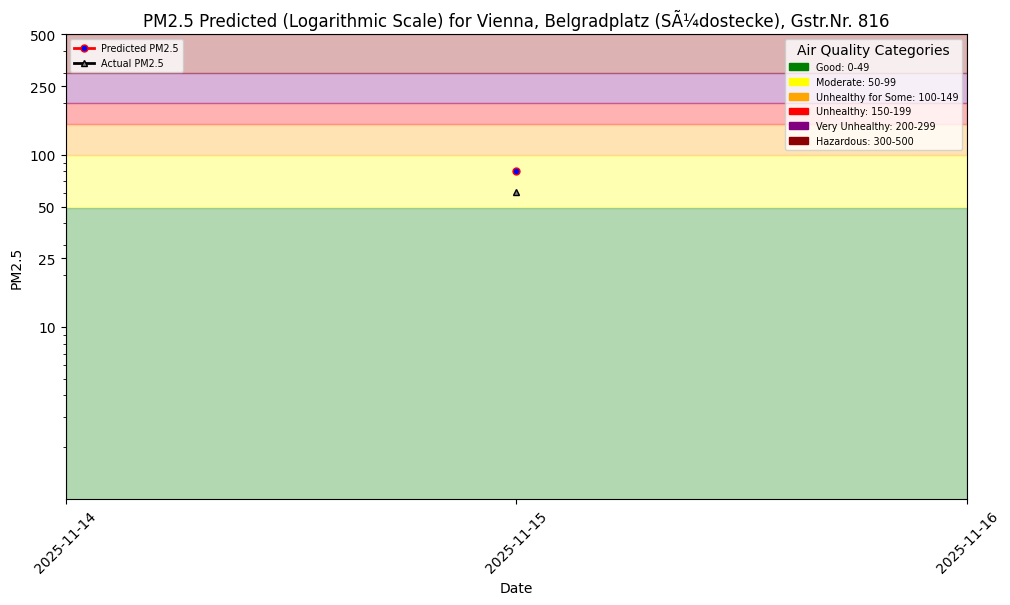

In [81]:
# --- Block 3: Generate and save hindcast plot for ONE station ---
base_img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(base_img_dir, exist_ok=True)

STATION_UID, CITY, STREET, hindcast_df = hindcast_results[0]

# Create subfolder for this station
station_dir = os.path.join(base_img_dir, str(STATION_UID))
os.makedirs(station_dir, exist_ok=True)

# Save plot under /img/<uid>/pm25_hindcast_1day.png
hindcast_file_path = os.path.join(station_dir, "pm25_hindcast_1day.png")

plt = util.plot_air_quality_forecast(
    CITY,
    STREET,
    hindcast_df,
    hindcast_file_path,
    hindcast=True,
)

hindcast_df["date"] = pd.to_datetime(hindcast_df["date"])

# Since there is one date
d = hindcast_df["date"].iloc[0]

ax = plt.gca()
ax.set_xlim(d - datetime.timedelta(days=1), d + datetime.timedelta(days=1))

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)


plt.savefig(hindcast_file_path, bbox_inches="tight")

#plt.show()
#plt.close()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [74]:
# --- Block 4: Upload hindcast plot to Hopsworks Datasets ---
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

# Ensure dataset directory exists in Hopsworks
if not dataset_api.exists("Resources/airquality"):
    dataset_api.mkdir("Resources/airquality")

STATION_UID, CITY, STREET, _ = hindcast_results[0]   # only one station

station_dir = os.path.join(base_img_dir, str(STATION_UID))
hindcast_file_path = os.path.join(station_dir, "pm25_hindcast_1day.png")

remote_path = f"Resources/airquality/{CITY}_{STATION_UID}_{str_today}"

dataset_api.upload(
    hindcast_file_path,
    remote_path,
    overwrite=True
)

print(f"☁️ Generated and uploaded plots for {STREET} (UID {STATION_UID}) to {remote_path}")

proj_url = project.get_url()
print(
    f"🌐 View hindcast images in Hopsworks:\n"
    f"{proj_url}/settings/fb/path/Resources/airquality"
)


Uploading C:\Users\lppap\Documents\master\scalable_ML\mlfs-book/docs/air-quality/assets/img\2870\pm25_hindcast…

☁️ Uploaded hindcast for Belgradplatz (SÃ¼dostecke), Gstr.Nr. 816 (UID 2870) to Resources/airquality/Vienna_2870_2025-11-15
🌐 View hindcast images in Hopsworks:
https://c.app.hopsworks.ai:443/p/1279154/settings/fb/path/Resources/airquality


---